# Equations of motion for segbot

This notebook makes use of [SymPy](https://docs.sympy.org/), which is a Python library for symbolic mathematics.

In [42]:
import sympy as sym
import numpy as np
from scipy import signal

from sympy.physics import mechanics
mechanics.init_vprinting()

Define physical constants, consistent with the URDF file:

In [2]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

Convert all physical constants to rational numbers:

In [3]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

Define variables (with a flag to indicate they are all real numbers — this helps simplify):

In [4]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

Compute equations of motion, excluding lateral and heading errors (see [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses)):

In [5]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

In [6]:
M

Matrix([
[           78/5,                                                            0, 18*cos(theta)/5],
[              0, 4289*sin(theta)**2/2000 + 1169*cos(theta)**2/2000 + 441/1000,               0],
[18*cos(theta)/5,                                                            0,         108/125]])

In [7]:
N

Matrix([
[                      (18*thetadot**2/5 + 18*w**2/5)*sin(theta)],
[-444*thetadot*w*sin(theta)*cos(theta)/125 - 18*v*w*sin(theta)/5],
[               39*w**2*sin(theta)*cos(theta)/25 + 18*sin(theta)]])

In [8]:
R

Matrix([
[ 40/13, 40/13],
[-14/13, 14/13],
[    -1,    -1]])

Compute full equations of motion:

In [9]:
M = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

Display the vector-valued function $f$ for which the equations of motion can be written as

$$\begin{bmatrix} \dot{e}_\text{lateral} \\ \dot{e}_\text{heading} \\ \dot{v} \\ \dot{w} \\ \ddot{\theta} \end{bmatrix} = f(e_\text{lateral}, e_\text{heading}, v, w, \theta, \dot{\theta}, \tau_R, \tau_L)$$

In [10]:
M

Matrix([
[                                                                                                                                                                           v*sin(e_h)],
[                                                                                                                                                                                    w],
[        -(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                    32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(thetadot**2 + w**2)*sin(theta))*cos(theta) - 76050*sin(theta))/(702*(25*cos(theta)**2 - 26))]])

In [11]:
omega_p = sym.symbols('omega_p')
f = f.subs(thetadot, omega_p)
M = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [omega_p],
                [f]])
equations_M = M

In [12]:
M = M.subs(w, 0)
M = M.subs(omega_p, 0)
M = M.subs(e_h, 0)
M = M.subs(tau_R, 0)
M = M.subs(tau_L, 0)

In [13]:
y1 = M[3]
y2 = M[5]
M

Matrix([
[                                                      0],
[                                                      0],
[                                                      0],
[29250*sin(theta)*cos(theta)/(5850*cos(theta)**2 - 6084)],
[                                                      0],
[           -1625*sin(theta)/(3*(25*cos(theta)**2 - 26))]])

In [14]:
from numpy import sqrt, arctan
th = sym.solve(y1 - y2, theta)

In [15]:
th

[0]

In [16]:
M = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [omega_p],
                [f]])
M = M.subs(w, 0)
M = M.subs(omega_p, 0)
M = M.subs(e_h, 0)
M = M.subs(tau_R, 0)
M = M.subs(tau_L, 0)

for i in th:
    M = M.subs(theta, i)
    print(i, M)
    M = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [omega_p],
                [f]])
    M = M.subs(w, 0)
    M = M.subs(omega_p, 0)
    M = M.subs(e_h, 0)
    M = M.subs(tau_R, 0)
    M = M.subs(tau_L, 0)

0 Matrix([[0], [0], [0], [0], [0], [0]])


In [30]:
we, omega_pe, e_he, tau_Re, tau_Le, theta_e, ve = 0, 0, 0, 0, 0, 0, 1


x = sym.Matrix([e_l, e_h, v, w, theta, omega_p])
u = sym.Matrix([tau_R, tau_L])

dyn = equations_M.jacobian(x)
controls = equations_M.jacobian(u)

a = sym.lambdify((e_h, e_l, v, theta, w, tau_R, tau_L, omega_p), dyn)
A = np.array(a(e_he, 0, ve, theta_e, we, tau_Re, tau_Le, omega_pe))

b = sym.lambdify((e_h, e_l, v, theta, w, tau_R, tau_L, omega_p), controls)
B = np.array(b(e_he, 0, ve, theta_e, we, tau_Re, tau_Le, omega_pe))

W = np.block([B, A@B, A@A@B, A@A@A@B, A@A@A@A@B, A@A@A@A@A@B])
print(np.linalg.matrix_rank(W))

6


In [47]:
B

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [ 12.07264957,  12.07264957],
       [  1.05014439,  -1.05014439],
       [-51.46011396, -51.46011396]])

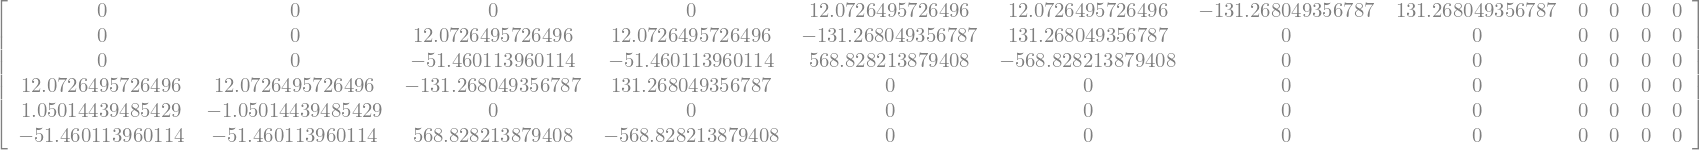

In [40]:
W_tex = sym.Matrix(W)
W_tex

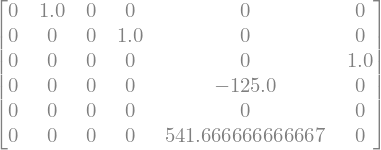

In [38]:
A_tex = sym.Matrix(A)
A_tex

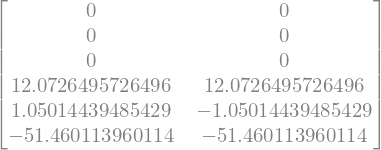

In [36]:
B_tex = sym.Matrix(B)
B_tex

In [41]:
print(f'{mechanics.mlatex(W_tex)}')

\left[\begin{array}{cccccccccccc}0 & 0 & 0 & 0 & 12.0726495726496 & 12.0726495726496 & -131.268049356787 & 131.268049356787 & 0 & 0 & 0 & 0\\0 & 0 & 12.0726495726496 & 12.0726495726496 & -131.268049356787 & 131.268049356787 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & -51.460113960114 & -51.460113960114 & 568.828213879408 & -568.828213879408 & 0 & 0 & 0 & 0 & 0 & 0\\12.0726495726496 & 12.0726495726496 & -131.268049356787 & 131.268049356787 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\1.05014439485429 & -1.05014439485429 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\-51.460113960114 & -51.460113960114 & 568.828213879408 & -568.828213879408 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{array}\right]


Note that one of these ODEs is second-order — you will have to replace this with a set of two first-order ODEs, as usual.

In [43]:
poles = [-1, -2, -3, -4, -5, -6]
K_list = signal.place_poles(A, B, poles)

In [44]:
K = K_list.gain_matrix

array([[  9.80632643,  19.68009126,   2.91028154,  12.32958923,
          0.81052894,   2.58376909],
       [ -9.40887809, -19.12874974,  -3.11953575, -12.12602643,
        -11.29126776,  -2.69713502]])

In [45]:
K_list.computed_poles

array([-5.99999999, -5.        , -4.        , -3.        , -2.        ,
       -1.        ])

In [46]:
K_list.requested_poles

array([-6., -5., -4., -3., -2., -1.])